# Iteratively Reweighted Least Squares Regression

Ordinary Least Squares `OLS` regression has an assumption that observations are [independently and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) `IID`. However, quite often, we find that our data violates this assumption. Two common sources of this violation arise from the following.

- serial autocorrelation: observations from longitudinal data (e.g. time-series data) are more similar the closer they are together in time and their residuals are correlated.
- repeated observations: observations are related to one another (e.g. students can be clustered by teachers) and so residuals are clustered.

When the IID assumption is violated, the variance of the residuals will not be constant but changing based on something in your model. This non-constant variance of the residual is called `heteroscedasticity`. A diagnostic plot of the residuals $r$ against the predicted values $\hat{y}$ might show that as values of $\hat{y}$ increases, the variance of $r$ increases as well.

Interestingly, violation of the IID assumption does not bias the estimation of the weights (intercept and coefficients). Rather, violation of the IID assumption will bias the `standard error` estimation of the weights. Additionally, with the difficulty in estimating the standard error as a result of correlation in the residuals, the model is no longer considered the [Best Linear Unbiased Estimator](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) `BLUE`. To deal with the bias estimation of the standard errors, there's a few things to do.

- [multilevel modeling](https://en.wikipedia.org/wiki/Multilevel_model): change the model; get a better model
- [robust standard error](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors): change the standard error estimator; get a better estimator
- [Iteratively Reweighted Least Squares Regression](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) `IRWLS`; weight the data and keep regression until convergence of the weights (coefficients)

In this notebook, we will go over how to multilevel modeling and how to implement IRWLS.

## Data

This data is a taken from the [GMU Comparative Effectiveness](http://openonlinecourses.com/causalanalysis/Multi%20Level%20Regression.asp) course. This data is composed of patient-level data across 6 hospitals (A, B, C, D, E, F) concerning their probability of survival. Certainly, this data has observations that are related to one another as patients may be grouped under hospitals (e.g. like students being grouped by teachers). The observations are not IID and there is risk for heteroscedasticity. 

In [1]:
import pandas as pd

df = pd.read_excel('./data/TraumaData.xlsx').drop(columns=['Unnamed: 0'])
df = df.rename(columns={c: c.lower().replace(' ', '_') for c in df.columns})
df = df.rename(columns={'65+_years': 'is_senior'})
df.shape

(50, 6)

In [2]:
df.head()

,prob_survival,severe_burn,head_injury,is_senior,male,hosp
0,0.694551,1,1,1,1,A
1,0.733619,1,1,1,0,A
2,0.785537,1,1,0,1,A
3,0.818770,1,0,1,1,A
4,0.868275,1,0,0,1,A


## Multilevel modeling, Intercept method

One way to do multilevel modeling is to build two regression models, one called the `micro-level model` (e.g. patients, students), and another afterwards, called the `macro-level model` (e.g. hospitals, teachers). 

In [3]:
from patsy import dmatrices
import statsmodels.api as sm
import numpy as np

np.random.seed(37)

y, X = dmatrices('prob_survival ~ severe_burn + head_injury + is_senior + male + hosp', df, return_type='dataframe')
y = np.ravel(y)
X = X.iloc[:,1:]

X.shape, y.shape

((50, 8), (50,))

### Micro-level (patients)

In the micro-level model, all variables are regressed against the dependent variable (probability of survival, in this case). The grouping variable denoting hospital is one-hot encoded (with Hospital A being dropped as the reference) to produce dummy variables. The coefficients associated dummy variables are then used as the dependent variable in the macro-level model.

In [4]:
from sklearn.linear_model import LinearRegression

def get_coef(m, X=None):
    if X is None:
        return np.array([m.intercept_] + list(m.coef_))
    return pd.concat([
                pd.Series(m.intercept_, ['intercept']), 
                pd.Series(m.coef_, X.columns)
            ])

m1 = LinearRegression()
m1.fit(X, y)

c1 = get_coef(m1, X)
c1

intercept      1.162184
hosp[T.B]     -0.117932
hosp[T.C]     -0.226131
hosp[T.D]     -0.276450
hosp[T.E]     -0.341136
severe_burn   -0.245425
head_injury   -0.181782
is_senior     -0.109293
male          -0.026703
dtype: float64

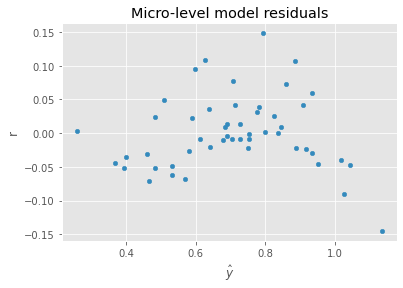

In [5]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

ax = pd.DataFrame({'y': m1.predict(X), 'r': y - m1.predict(X)}).plot(kind='scatter', x='y', y='r', xlabel=r'$\hat{y}$')
_ = ax.set_title('Micro-level model residuals')

### Macro-level (hospitals)

Before we can use the coefficients of the dummy variables (from the grouping variable), we need to adjust them using the intercept (remember, we dropped one of the dummy variables and considered it the reference). The adjustment is simply the intercept minus the coefficient, which becomes the dependent variable at the macro-level model. We can use the macro-level model to understand macro-level variables and how they influence the probability of survival. 

In [6]:
hosp_df = pd.DataFrame({
    'tertiary_center': [1, 1, 0, 0, 0],
    'burn_center': [0, 1, 0, 0, 0],
    'y': [0] + list(m1.intercept_ - c1[1:5])
}, index=['A', 'B', 'C', 'D', 'E'])

hosp_df

,tertiary_center,burn_center,y
A,1,0,0.000000
B,1,1,1.280116
C,0,0,1.388314
D,0,0,1.438634
E,0,0,1.503320


In [7]:
y, X = dmatrices('y ~ tertiary_center + burn_center', hosp_df, return_type='dataframe')
y = np.ravel(y)
X = X.iloc[:,1:]

X.shape, y.shape

((5, 2), (5,))

In [8]:
m2 = LinearRegression()
m2.fit(X, y)

c2 = get_coef(m2, X)
c2

intercept          1.443422
tertiary_center   -1.443422
burn_center        1.280116
dtype: float64

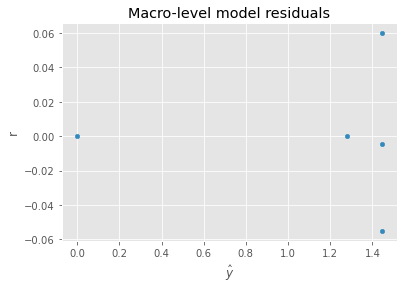

In [9]:
ax = pd.DataFrame({'y': m2.predict(X), 'r': y - m2.predict(X)}).plot(kind='scatter', x='y', y='r', xlabel=r'$\hat{y}$')
_ = ax.set_title('Macro-level model residuals')

## Regression, y ~ X

We can also apply `OLS` directly on the data.

In [10]:
df['tertiary_center'] = df['hosp'].apply(lambda h: 1 if h in {'A', 'B'} else 0)
df['burn_center'] = df['hosp'].apply(lambda h: 1 if h in {'B'} else 0)

df.head()

,prob_survival,severe_burn,head_injury,is_senior,male,hosp,tertiary_center,burn_center
0,0.694551,1,1,1,1,A,1,0
1,0.733619,1,1,1,0,A,1,0
2,0.785537,1,1,0,1,A,1,0
3,0.818770,1,0,1,1,A,1,0
4,0.868275,1,0,0,1,A,1,0


In [11]:
y, X = dmatrices('prob_survival ~ severe_burn + head_injury + is_senior + male + hosp + tertiary_center + burn_center', df, return_type='dataframe')
y = np.ravel(y)
X = X.iloc[:,1:]

X.shape, y.shape

((50, 10), (50,))

In [12]:
m3 = LinearRegression()
m3.fit(X, y)

c3 = get_coef(m3, X)
c3

intercept          0.951254
hosp[T.B]         -0.058966
hosp[T.C]         -0.015202
hosp[T.D]         -0.065521
hosp[T.E]         -0.130207
severe_burn       -0.245425
head_injury       -0.181782
is_senior         -0.109293
male              -0.026703
tertiary_center    0.210929
burn_center       -0.058966
dtype: float64

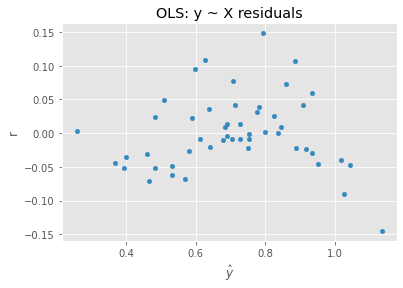

In [13]:
ax = pd.DataFrame({'y': m3.predict(X), 'r': y - m3.predict(X)}).plot(kind='scatter', x='y', y='r', xlabel=r'$\hat{y}$')
_ = ax.set_title('OLS: y ~ X residuals')

## Regression, log(y) ~ X

We can try to control the residual heteroscedasticity by taking the log of the dependent variable.

In [14]:
m4 = LinearRegression()
m4.fit(X, np.log(y))

c4 = get_coef(m4, X)
c4

intercept         -0.015569
hosp[T.B]         -0.092775
hosp[T.C]         -0.018212
hosp[T.D]         -0.084913
hosp[T.E]         -0.240481
severe_burn       -0.404063
head_injury       -0.269846
is_senior         -0.153650
male              -0.055098
tertiary_center    0.343607
burn_center       -0.092775
dtype: float64

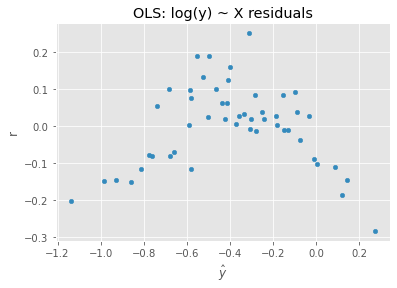

In [15]:
ax = pd.DataFrame({'y': m4.predict(X), 'r': np.log(y) - m4.predict(X)}).plot(kind='scatter', x='y', y='r', xlabel=r'$\hat{y}$')
_ = ax.set_title('OLS: log(y) ~ X residuals')

## IRWLS, y ~ X

IRWLS can be applied where we inversely weight each observation by their residual and apply weighted least squares repeatedly until the weights/coefficients converge.

In [16]:
def do_irwls(X, y, max_iter=100, delta=0.001, tol=0.001):
    w = np.ones(y.shape[0])

    m = LinearRegression()
    m.fit(X, y, w)

    trace = []

    for i in range(max_iter):
        _B = get_coef(m)
        _w = 1 / np.maximum(delta, np.abs(y - m.predict(X)))

        m = LinearRegression()
        m.fit(X, y, _w)

        B = get_coef(m)
        w = 1 / np.maximum(delta, np.abs(y - m.predict(X)))

        B_dist = np.linalg.norm(B - _B)
        w_dist = np.linalg.norm(w - _w)

        B_delta = np.sum(np.abs(B - _B))
        w_delta = np.sum(np.abs(w - _w))

        trace.append({'i': i, 'w_dist': w_dist, 'w_delta': w_delta, 'B_dist': B_dist, 'B_delta': B_delta})

        if B_delta < tol:
            break

    return m, pd.DataFrame(trace)

m5, trace_df = do_irwls(X, y, delta=0.0001, tol=0.0001)

c5 = get_coef(m5, X)
c5

intercept          0.941122
hosp[T.B]         -0.056463
hosp[T.C]         -0.012746
hosp[T.D]         -0.070542
hosp[T.E]         -0.128975
severe_burn       -0.251367
head_injury       -0.175856
is_senior         -0.096670
male              -0.028194
tertiary_center    0.212263
burn_center       -0.056463
dtype: float64

Here is the trace of how the weights of the observations (w_dist, w_delta) and coefficients (B_dist, B_delta) change over the iterations.

In [17]:
trace_df

,i,w_dist,w_delta,B_dist,B_delta
0,0,2920.326019,5159.839926,0.010612,0.028483
1,1,6115.516835,8481.150242,0.003541,0.009355
2,2,762.006315,2037.056610,0.003275,0.008592
3,3,1598.830939,3631.665480,0.002668,0.007217
4,4,3480.849759,6502.227517,0.001484,0.004030
5,5,4448.407014,7498.270822,0.000537,0.001357
6,6,6805.783694,10404.790335,0.000318,0.000765
7,7,1256.220294,1794.883870,0.000108,0.000260
8,8,47.144100,100.626159,0.000017,0.000040


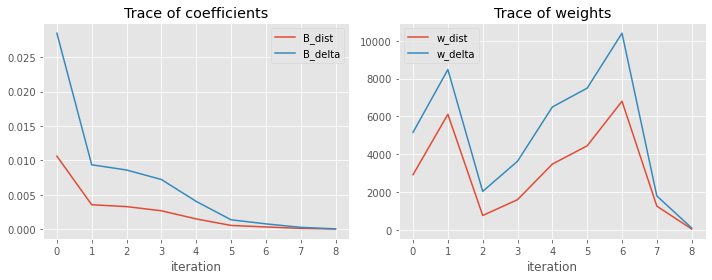

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

_ = trace_df[['B_dist', 'B_delta']].plot(kind='line', ax=ax[0], xlabel='iteration')
_ = trace_df[['w_dist', 'w_delta']].plot(kind='line', ax=ax[1], xlabel='iteration')

_ = ax[0].set_title('Trace of coefficients')
_ = ax[1].set_title('Trace of weights')

plt.tight_layout()

## Comparing coefficients

Let's compare the coefficients of the models.

- `ML-1`: is multilevel model, micro-model
- `OLS`: is OLS with y ~ X
- `LOG_OLS`: is OLS with log(y) ~ X
- `IRWLS`: is simply IRWLS with y ~ X

In [19]:
pd.DataFrame([c1, c3, c4, c5], index=['ML-1', 'OLS', 'LOG_OLS', 'IRWLS']).T

,ML-1,OLS,LOG_OLS,IRWLS
intercept,1.162184,0.951254,-0.015569,0.941122
hosp[T.B],-0.117932,-0.058966,-0.092775,-0.056463
hosp[T.C],-0.226131,-0.015202,-0.018212,-0.012746
hosp[T.D],-0.276450,-0.065521,-0.084913,-0.070542
hosp[T.E],-0.341136,-0.130207,-0.240481,-0.128975
severe_burn,-0.245425,-0.245425,-0.404063,-0.251367
head_injury,-0.181782,-0.181782,-0.269846,-0.175856
is_senior,-0.109293,-0.109293,-0.153650,-0.096670
male,-0.026703,-0.026703,-0.055098,-0.028194
tertiary_center,NaN,0.210929,0.343607,0.212263


## Comparing the residuals visually

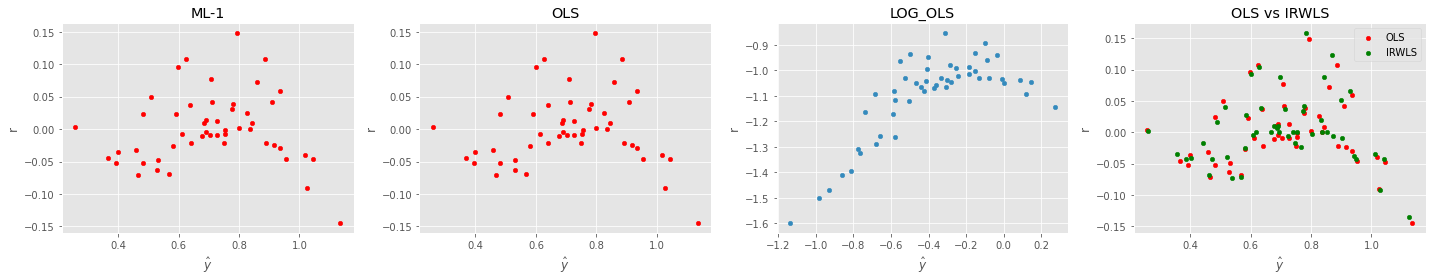

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

_ = pd.DataFrame({'y': m1.predict(X.iloc[:,:8]), 'r': y - m1.predict(X.iloc[:,:8])}).plot(kind='scatter', x='y', y='r', ax=ax[0], color='red', xlabel=r'$\hat{y}$')
_ = pd.DataFrame({'y': m3.predict(X), 'r': y - m3.predict(X)}).plot(kind='scatter', x='y', y='r', ax=ax[1], color='red', xlabel=r'$\hat{y}$')
_ = pd.DataFrame({'y': m4.predict(X), 'r': np.log(y) - m3.predict(X)}).plot(kind='scatter', x='y', y='r', ax=ax[2], xlabel=r'$\hat{y}$')
_ = pd.DataFrame({'y': m3.predict(X), 'r': y - m3.predict(X)}).plot(kind='scatter', x='y', y='r', ax=ax[3], color='red', label='OLS', xlabel=r'$\hat{y}$')
_ = pd.DataFrame({'y': m5.predict(X), 'r': y - m5.predict(X)}).plot(kind='scatter', x='y', y='r', ax=ax[3], color='green', label='IRWLS', xlabel=r'$\hat{y}$')

_ = ax[0].set_title('ML-1')
_ = ax[1].set_title('OLS')
_ = ax[2].set_title('LOG_OLS')
_ = ax[3].set_title('OLS vs IRWLS')

plt.tight_layout()

## Comparing standard errors

Now we can compare the standard error estimation using bootstrap sampling. We will compare OLS with IRWLS.

In [21]:
import scipy.stats


def get_sample(df):
    sample = df.sample(df.shape[0], replace=True)
    y, X = dmatrices('prob_survival ~ severe_burn + head_injury + is_senior + male + hosp + tertiary_center + burn_center', sample, return_type='dataframe')
    y = np.ravel(y)
    X = X.iloc[:,1:]
    
    return X, y

def do_reg(df, is_ols=True):
    X, y = get_sample(df)

    if is_ols:
        model = LinearRegression()
        model.fit(X, y)
    else:
        model, _ = do_irwls(X, y, delta=0.0001, tol=0.0001)

    params = get_coef(model, X)

    return params

def get_se(df, is_ols=True):
    y, X = dmatrices('prob_survival ~ severe_burn + head_injury + is_senior + male + hosp + tertiary_center + burn_center', df, return_type='dataframe')
    y = np.ravel(y)
    X = X.iloc[:,1:]
    
    if is_ols:
        model = LinearRegression()
        model.fit(X, y)
    else:
        model, _ = do_irwls(X, y, delta=0.0001, tol=0.0001)
    
    w = get_coef(model, X)
    
    r_df = pd.DataFrame([do_reg(df, is_ols) for _ in range(100)])
    se = r_df.std()
    
    dof = X.shape[0] - X.shape[1] - 1
    
    summary = pd.DataFrame({
        'w': w,
        'se': se,
        'z': w / se,
        '.025': w - se,
        '.975': w + se,
        'df': [dof for _ in range(len(w))]
    })

    summary['P>|z|'] = scipy.stats.t.sf(abs(summary.z), df=summary.df)

    return summary

In [22]:
ols_df = get_se(df, is_ols=True) 
ols_df \
    .style \
    .applymap(lambda v: 'background-color: rgb(255, 0, 0, 0.18)' if v < 0.05 else '', subset=['P>|z|'])

,w,se,z,.025,.975,df,P>|z|
intercept,0.951254,0.027222,34.944054,0.924032,0.978477,39,0.000000
hosp[T.B],-0.058966,0.016798,-3.510404,-0.075764,-0.042169,39,0.000573
hosp[T.C],-0.015202,0.014735,-1.031645,-0.029937,-0.000466,39,0.154297
hosp[T.D],-0.065521,0.018918,-3.463351,-0.084439,-0.046603,39,0.000655
hosp[T.E],-0.130207,0.020051,-6.493915,-0.150257,-0.110156,39,0.000000
severe_burn,-0.245425,0.018974,-12.935064,-0.264398,-0.226451,39,0.000000
head_injury,-0.181782,0.020039,-9.071220,-0.201821,-0.161742,39,0.000000
is_senior,-0.109293,0.018184,-6.010370,-0.127477,-0.091109,39,0.000000
male,-0.026703,0.020152,-1.325102,-0.046855,-0.006551,39,0.096424
tertiary_center,0.210929,0.024780,8.512106,0.186149,0.235709,39,0.000000


In [23]:
irwls_df = get_se(df, is_ols=False) 
irwls_df \
    .style \
    .applymap(lambda v: 'background-color: rgb(255, 0, 0, 0.18)' if v < 0.05 else '', subset=['P>|z|'])

,w,se,z,.025,.975,df,P>|z|
intercept,0.941122,0.035170,26.759178,0.905952,0.976293,39,0.000000
hosp[T.B],-0.056463,0.023825,-2.369904,-0.080288,-0.032638,39,0.011418
hosp[T.C],-0.012746,0.019916,-0.640003,-0.032662,0.007170,39,0.262957
hosp[T.D],-0.070542,0.020053,-3.517723,-0.090596,-0.050489,39,0.000561
hosp[T.E],-0.128975,0.022705,-5.680358,-0.151680,-0.106269,39,0.000001
severe_burn,-0.251367,0.023692,-10.609974,-0.275058,-0.227675,39,0.000000
head_injury,-0.175856,0.030017,-5.858583,-0.205873,-0.145840,39,0.000000
is_senior,-0.096670,0.025729,-3.757309,-0.122399,-0.070942,39,0.000281
male,-0.028194,0.021105,-1.335924,-0.049299,-0.007090,39,0.094659
tertiary_center,0.212263,0.035038,6.058030,0.177225,0.247301,39,0.000000


In this data, OLS tends to result in standard errors that are smaller than IRWLS.

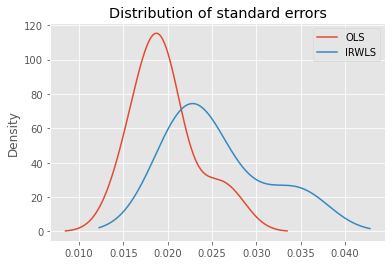

In [24]:
ax = ols_df['se'].plot(kind='kde', label='OLS')
_ = irwls_df['se'].plot(kind='kde', label='IRWLS', ax=ax)
_ = ax.set_title('Distribution of standard errors')
_ = ax.legend()